In [1]:
from compute import Var, eqvar, ureg, get_unit, buildidpvars, coupled_run, Evaluable, args_in_order, fill_args
from inputresolver import reassigneq, eqvars, eqsonly, default_out, mdf_order, default_in, idx_eqlist
from inputresolver import getallvars, invert_edges, resolve, reassign
from representations import bipartite_repr, drawbipartite, digraph_repr, draw
from compute_utils import get_outputs, check_eqs, print_out
from pprint import pprint
import networkx as nx
import sympy as sp
from sympy.utilities.lambdify import implemented_function
import numpy as np
from scipy import interpolate
import openmdao.api as om

Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


In [2]:
from functools import reduce
from itertools import chain
from collections import OrderedDict
import matplotlib.pyplot as plt

In [3]:
ureg.define('USD = [currency] ')

In [4]:
z_table = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40])*1e3
T_table_celsius = np.array([15, 8.5,2,-4.49,-10.98,-17.47,-23.96,-30.45,-36.94,-43.42,-49.9,-56.5,-56.5,-51.6,-46.64,-22.8])
T_table = ureg.Quantity(T_table_celsius, 'degC').to('K').magnitude
G_table = np.array([9.807,9.804,9.801,9.797,9.794,9.791,9.788,9.785,9.782,9.779,9.776,9.761,9.745,9.73,9.715,9.684])
P_table = np.array([10.13,8.988,7.95,7.012,6.166,5.405,4.722,4.111,3.565,3.08,2.65,1.211,0.5529,0.2549,0.1197,0.0287])*1e4
ρ_table = np.array([1.225,1.112,1.007,0.9093,0.8194,0.7364,0.6601,0.59,0.5258,0.4671,0.4135,0.1948,0.08891,0.04008,0.01841,0.003996])

In [5]:
Tinterp = interpolate.interp1d(z_table, T_table)
Ginterp = interpolate.interp1d(z_table, G_table)
Pinterp = interpolate.interp1d(z_table, P_table)
ρinterp = interpolate.interp1d(z_table, ρ_table)
T_int = Tinterp
G_int = Ginterp
P_int = Pinterp
ρ_int = ρinterp

In [6]:
def wrapper(f):
    def wrappedf(h):
        if isinstance(h, ureg.Quantity):
            h = h.to('m').magnitude
            print(h)
        return f(h)
    return wrappedf

In [7]:
rho = implemented_function(sp.Function('rho'),  wrapper(ρ_int))
T = implemented_function(sp.Function('T'),  wrapper(T_int))
P = implemented_function(sp.Function('P'),  wrapper(Pinterp))
G = implemented_function(sp.Function('G'),  wrapper(Ginterp))
rho0 = Var('rho0', ρ_int(0.01e3), 'kg/m^3', never_output=True)
T0 = Var('T0', T_int(0.01e3), 'K', never_output=True)
P0 = Var('P0', P_int(0.01e3), 'Pa', never_output=True)
G0 = Var('G0', G_int(0.01e3), 'm/s^2', never_output=True)
k = Var('k', 1.38064852e-23, 'J/K', never_output=True)
mm_He = Var('mm_He', 6.64e-27, 'kg', never_output=True)
mm_H2 = Var('mm_H2', 1.66e-27, 'kg', never_output=True)
#rho_He0 = Var('rho_He0', 0.1786, 'kg/m^3') perhaps useful
#rho_H0 = Var('rho_He0', 0.08988, 'kg/m^3')
C_D = Var('C_D', 0.47, never_output=True)

In [8]:
m_parafoil = Var('mv', 500., 'kg',never_output=True)
m_vhc = Var('mp', 4545., 'kg',never_output=True)
m_lg = Var('ml', unit='kg')
m_b = Var('mb', unit='kg')
m_tot, eq0 = eqvar('m_t', m_vhc+m_parafoil+m_lg+m_b, 'kg')
n_pax = Var('np', 8)
n_crew = Var('nc', 2)
mpp = Var('mpp', 100, 'kg')
#cpm_vhc = Var('c_rho', 2236, 'USD/kg')
#C_vhc, eq0b = eqvar('C_vhc', (m_vhc-(n_crew+n_pax)*mpp)*cpm_vhc)

In [9]:
z = Var('z', 30480, unit='m', never_output=True) 
rhoval, eq1 = eqvar('rhoval', rho(z), 'kg/m^3', forceunit=True)
pval, eq2 = eqvar('pval', P(z), 'Pa', forceunit=True)
Tval, eq3 = eqvar('Tval', T(z), 'K', forceunit=True)
gval, eq4 = eqvar('gval', G(z), 'm/s^2', forceunit=True)

In [10]:
alpha = Var('a', 1, never_output=True)
v_rise = Var('v', 6, 'm/s', never_output=True)

## Balloon Geometry at STP

In [11]:
r0 = Var('r0', unit='m')
A0, eq5 = eqvar('A0', np.pi*r0**2)
V0, eq6 = eqvar('V0', 4/3*np.pi*r0**3)
rho_LG0, eq7 = eqvar('rhoLG0', P0*(alpha*mm_He+(1-alpha)*mm_H2)/(k*T0))
eq8 = (m_lg, V0*rho_LG0)

Converge radius based on desired rise velocity

In [12]:
L0, eq9 = eqvar('L0', rho0*V0*G0)
W0, eq10 = eqvar('W0', m_tot*G0)
D0, eq11 = eqvar('D0', 1/2*C_D*rho0*v_rise**2*A0)
eq12 = (sp.S(0), L0-D0-W0)

### End of model

In [13]:
eq_list = [eq0,eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10,eq11,eq12]

In [14]:
eqs = idx_eqlist(eq_list)
eqv = eqvars(eqs)
dins = default_in(eqs)
dout = default_out(eqs)

In [15]:
eqs

{0: (m_t, mb + ml + mp + mv),
 1: (rhoval, rho(z)),
 2: (pval, P(z)),
 3: (Tval, T(z)),
 4: (gval, G(z)),
 5: (A0, 3.14159265358979*r0**2),
 6: (V0, 4.18879020478639*r0**3),
 7: (rhoLG0, P0*(a*mm_He + mm_H2*(1 - a))/(T0*k)),
 8: (ml, V0*rhoLG0),
 9: (L0, G0*V0*rho0),
 10: (W0, G0*m_t),
 11: (D0, 0.5*A0*C_D*rho0*v**2),
 12: (0, -D0 + L0 - W0)}

In [16]:
new_ins = dins#.union(force_input) - set(not_input)
new_eqv = {key: {elt for elt in outsetposs if not elt.never_output}
        for key, outsetposs in eqv.items()}

In [242]:
BG, edges_original = bipartite_repr(new_eqv)
M = nx.bipartite.maximum_matching(BG)
newdout = {key:M[key] for key in dout.keys()}

AmbiguousSolution: Disconnected graph: Ambiguous solution for bipartite sets.

## Balloon Geometry at target altitude

In [196]:
rz = Var('rz', unit='m')
hz, eq13 = eqvar('hz', 2*(3/2)*rz)
Vz, eq14 = eqvar('Vz', 4/3*np.pi*rz**3)
rho_LGz, eq15 = eqvar('rhoLGz', pval*(alpha*mm_He+(1-alpha)*mm_H2)/(k*Tval))

Converge radius based on mass constraint

In [197]:
eq16 = (sp.S(0), m_lg-Vz*rho_LGz) #needs to have same mass as balloon at STP

Converge altitude based on steady state

In [198]:
Lz, eq17 = eqvar('Lz', rhoval*Vz*gval)
Wz, eq18 = eqvar('Wz', m_tot*gval)
eq19 = (sp.S(0), Lz-Wz) # 

Mass calculations

In [199]:
t_LLDPE = Var('tL', 5.4*10e-6*1, 'm', never_output=True)
rho_LLDPE = Var('rhoL', 925, 'kg/m^3', never_output=True)
p = Var('p', 1.6, never_output=True) #some parameter
S, eq20 = eqvar('S', 4*np.pi*((rz**(2*p)+2*rz**p*(hz/2)**p)/3)**(1/p))
eq21 = (m_b, 2*(3/2)*S*t_LLDPE*rho_LLDPE)

# Visualization

In [200]:
eq_list = [eq0, eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10,eq11,eq12,eq13,eq14,eq15,eq16,eq17,eq18,eq19,eq20,eq21]

In [201]:
eqs = idx_eqlist(eq_list)
eqv = eqvars(eqs)

In [202]:
dins = default_in(eqs)
dout = default_out(eqs)

In [203]:
new_ins = dins#.union(force_input) - set(not_input)
new_eqv = {key: {elt for elt in outsetposs if not elt.never_output}
        for key, outsetposs in eqv.items()}

In [204]:
new_eqv

{0: {m_t, mb, ml},
 1: {rhoval},
 2: {pval},
 3: {Tval},
 4: {gval},
 5: {A0, r0},
 6: {V0, r0},
 7: {rhoLG0},
 8: {V0, ml, rhoLG0},
 9: {L0, V0},
 10: {W0, m_t},
 11: {A0, D0},
 12: {D0, Fe, L0, W0},
 13: {hz, rz},
 14: {Vz, rz},
 15: {Tval, pval, rhoLGz},
 16: {Vz, ml, rhoLGz},
 17: {Lz, Vz, gval, rhoval},
 18: {Wz, gval, m_t},
 19: {Lz, Wz},
 20: {S, hz, rz},
 21: {S, mb}}

In [205]:
BG, edges_original = bipartite_repr(new_eqv)
M = nx.bipartite.maximum_matching(BG)
newdout = {key:M[key] for key in dout.keys()}

In [206]:
getallvars(eqs)-set(newdout.values())-{0}

{C_D, G0, P0, T0, a, k, mm_H2, mm_He, mp, mv, p, rho0, rhoL, tL, v, z}

In [207]:
DG, edges = digraph_repr(new_eqv, newdout, intermediary=False)

In [208]:
list(nx.strongly_connected_components(DG))

[{Fe},
 {D0},
 {A0},
 {r0},
 {L0},
 {V0},
 {W0},
 {Lz, S, Vz, Wz, hz, m_t, mb, ml, rz},
 {rhoLG0},
 {rhoLGz},
 {Tval},
 {pval},
 {gval},
 {rhoval}]

In [209]:
dgin = {n for n in DG.nodes if len(list(DG.predecessors(n)))==0}

In [220]:
# #draw(DG, figsize=(15,15), node_shape='o', prog='neato')
# prog='dot'
# node_shape='o'
# edge_color='k'
# width=2
# arc=False
# figsize=(15,15)
# node_size=1000
# labels = OrderedDict([(elt,r'${}$'.format(str(elt))) for elt in DG.nodes])
# pos = nx.drawing.nx_pydot.graphviz_layout(DG, prog=prog)
# plt.figure(figsize=figsize)
# plt.margins(0.15)
# nx.draw_networkx_nodes(DG, pos=pos, node_size=node_size, node_color='lightgreen', 
#     linewidths=2, edgecolors='k', node_shape=node_shape, nodelist=list(dgin))
# nx.draw_networkx_nodes(DG, pos=pos, node_size=node_size, node_color='w', 
#     linewidths=2, edgecolors='k', node_shape=node_shape, nodelist =set(DG.nodes)-dgin)
# #https://stackoverflow.com/questions/22785849/drawing-multiple-edges-between-two-nodes-with-networkx
# connectionstyle = 'arc3, rad = 0.1' if arc else None
# nx.draw_networkx_edges(DG, pos=pos, arrowsize=20, width=width, 
#     edge_color=edge_color, connectionstyle=connectionstyle)
# nx.draw_networkx_labels(DG, pos, labels, font_size=20)
# plt.gca().axis("off");

In [221]:
new_order = mdf_order(new_eqv, newdout)

In [227]:
order_flattened = []
for elt in new_order:
    if type(elt)==tuple:
        order_flattened.extend(elt)
    else:
        order_flattened.append(elt)

In [234]:
order_flattened

[1, 4, 2, 3, 15, 20, 17, 14, 13, 21, 19, 0, 18, 16, 10, 7, 8, 9, 6, 5, 11, 12]

In [229]:
m = nx.adjacency_matrix(DG)

In [232]:
eqorder = order_flattened #2,1,3,4
labels = OrderedDict([(elt,r'${}$'.format(str(elt))) for elt in DG.nodes])
dsm_labels = [labels[newdout[elt]] for elt in eqorder]
node_order = list(DG.nodes())
index_order = [node_order.index(newdout[elt]) for elt in eqorder]
#https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
dsm = m.todense()[np.ix_(index_order,index_order)].astype(np.float32)
dsm[np.diag_indices(len(dsm))]=0.5

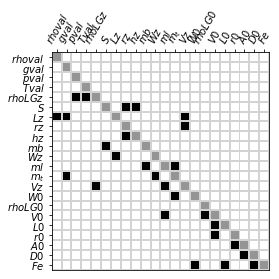

In [236]:
#plt.matshow(dsm.T, cmap='Greys',  interpolation='nearest');
fig = plt.pcolormesh(dsm.T, cmap='Greys', edgecolors='lightgray', linewidth=1, vmin=0, vmax=1)
ax = plt.gca()
ax.invert_yaxis()
ax.set_aspect('equal')
a,b = zip(*enumerate(dsm_labels))
plt.xticks(np.array(a)+0.5,b, rotation = 60);
plt.yticks(np.array(a)+0.5,b);
ax.xaxis.tick_top()

In [223]:
new_eqv

{0: {m_t, mb, ml},
 1: {rhoval},
 2: {pval},
 3: {Tval},
 4: {gval},
 5: {A0, r0},
 6: {V0, r0},
 7: {rhoLG0},
 8: {V0, ml, rhoLG0},
 9: {L0, V0},
 10: {W0, m_t},
 11: {A0, D0},
 12: {D0, Fe, L0, W0},
 13: {hz, rz},
 14: {Vz, rz},
 15: {Tval, pval, rhoLGz},
 16: {Vz, ml, rhoLGz},
 17: {Lz, Vz, gval, rhoval},
 18: {Wz, gval, m_t},
 19: {Lz, Wz},
 20: {S, hz, rz},
 21: {S, mb}}

## Calculations

In [212]:
new_eqs = reassign(eqs, newdout)

In [213]:
new_eqs

{0: (ml, m_t - mb - mp - mv),
 1: (rhoval, rho(z)),
 2: (pval, P(z)),
 3: (Tval, T(z)),
 4: (gval, G(z)),
 5: (A0, 3.14159265358979*r0**2),
 6: (r0, 0.620350490899399*V0**(1/3)),
 7: (rhoLG0, P0*(-a*mm_H2 + a*mm_He + mm_H2)/(T0*k)),
 8: (V0, ml/rhoLG0),
 9: (L0, G0*V0*rho0),
 10: (W0, G0*m_t),
 11: (D0, 0.5*A0*C_D*rho0*v**2),
 12: (Fe, -D0 + L0 - W0),
 13: (hz, 3.0*rz),
 14: (rz, 0.620350490899399*Vz**(1/3)),
 15: (rhoLGz, pval*(-a*mm_H2 + a*mm_He + mm_H2)/(Tval*k)),
 16: (Vz, ml/rhoLGz),
 17: (Lz, Vz*gval*rhoval),
 18: (m_t, Wz/gval),
 19: (Wz, Lz),
 20: (S,
  12.5663706143592*(0.333333333333333*2.0**(-p)*rz**p*(2.0**p*rz**p + 2.0*hz**p))**(1/p)),
 21: (mb, 3.0*S*rhoL*tL)}

In [214]:
new_ins = default_in(new_eqs)

In [215]:
dins;

In [216]:
new_order

[1,
 4,
 2,
 3,
 15,
 (20, 17, 14, 13, 21, 19, 0, 18, 16),
 10,
 7,
 8,
 9,
 6,
 5,
 11,
 12]

In [217]:
z.varval

30480

In [218]:
prob = om.Problem()
model = prob.model
buildidpvars(new_ins, model)
counter = coupled_run(new_eqs, new_order, (), model, model)
prob.setup()
prob.run_model()

eq1 rhoval rho(z) None
eq4 gval G(z) None
eq2 pval P(z) None
eq3 Tval T(z) None
eq15 rhoLGz pval*(-a*mm_H2 + a*mm_He + mm_H2)/(Tval*k) None
eq20 S 12.5663706143592*(0.333333333333333*2.0**(-p)*rz**p*(2.0**p*rz**p + 2.0*hz**p))**(1/p) None
eq17 Lz Vz*gval*rhoval None
eq14 rz 0.620350490899399*Vz**(1/3) None
eq13 hz 3.0*rz None
eq21 mb 3.0*S*rhoL*tL None
eq19 Wz Lz None
eq0 ml m_t - mb - mp - mv None
eq18 m_t Wz/gval None
eq16 Vz ml/rhoLGz None
eq10 W0 G0*m_t None
eq7 rhoLG0 P0*(-a*mm_H2 + a*mm_He + mm_H2)/(T0*k) None
eq8 V0 ml/rhoLG0 None
eq9 L0 G0*V0*rho0 None
eq6 r0 0.620350490899399*V0**(1/3) None
eq5 A0 3.14159265358979*r0**2 None
eq11 D0 0.5*A0*C_D*rho0*v**2 None
eq12 Fe -D0 + L0 - W0 None

group1.group2
NL: NewtonSolver 'NL: Newton' on system 'group1.group2': residuals contain 'inf' or 'NaN' after 1 iterations.


<lambdifygenerated-188>:2: RuntimeWarning: invalid value encountered in power
  return (12.5663706143592*(0.333333333333333*2.0**(-p)*rz**p*(2.0**p*rz**p + 2.0*hz**p))**(p**(-1)))
<lambdifygenerated-190>:2: RuntimeWarning: invalid value encountered in power
  return (0.620350490899399*Vz**(1/3))
<lambdifygenerated-201>:2: RuntimeWarning: invalid value encountered in power
  return (0.620350490899399*V0**(1/3))


In [219]:
model.list_outputs();

38 Explicit Output(s) in 'model'

varname     value           
----------  ----------------
inp
  T0        [288.085]       
  mv        [500.]          
  z         [30480.]        
  p         [1.6]           
  tL        [5.4e-05]       
  mp        [4545.]         
  mm_H2     [1.66e-27]      
  G0        [9.80697]       
  mm_He     [6.64e-27]      
  rho0      [1.22387]       
  v         [6.]            
  C_D       [0.47]          
  P0        [101185.8]      
  a         [1.]            
  rhoL      [925.]          
  k         [1.38064852e-23]
group1
  eq1
    rhoval  [0.01771813]    
  eq4
    gval    [9.713512]      
  eq2
    pval    [1153.32]       
  eq3
    Tval    [227.65432]     
  eq15
    rhoLGz  [0.00243646]    
  group2
    eq20
      S     [nan]           
    eq17
      Lz    [-1178.96408194]
    eq14
      rz    [nan]           
    eq13
      hz    [-4248.31561101]
    eq21
      mb    [-5149.68327092]
    eq19
      Wz    [-1178.96408194]
    eq0
      ml    

# For later

In [35]:
# w_LLDPE = Var('wL', 9, 'ft')
# n_LLDPE, eq18 = eqvar('n_LLDPE', 2*sp.ceil(2*np.pi*r/w_LLDPE))
# TOF = Var('TOF', 8, 'hr')

In [36]:
# # Construction
# h_LLDPE = Var('hL', 18, 'hr')
# H_LLDPE, eq19 = eqvar('H_LLDPE', n_LLDPE*h_LLDPE)
# # d, eq21 = eqvar('d', d_drive/d_crow)      